# Theory: Boltzmann Transport Equation (BTE)

This notebook implements the transport coefficient calculations following the formalism of **Madsen & Singh (2006)** and the **BoltzTraP2 (2018)** code. 

The approach relies on the **Rigid Band Approximation (RBA)** and the **Constant Relaxation Time Approximation (CRTA)** to calculate transport properties from the electronic band structure.

---

## 1. Generalized Transport Integrals
The core of the BoltzTraP formalism is the calculation of **generalized transport moments** $\mathcal{L}^{(\alpha)}$. All macroscopic transport coefficients (conductivity, Seebeck, etc.) are derived from these moments.

The generalized moment for order $\alpha$ is defined as:

$$\mathcal{L}^{(\alpha)}(\mu, T) = \int_{-\infty}^{\infty} \Sigma(\varepsilon) (\varepsilon - \mu)^{\alpha} \left( -\frac{\partial f_0}{\partial \varepsilon} \right) d\varepsilon$$

In the discrete k-point summation form used by the code:

$$\mathcal{L}^{(\alpha)}(\mu, T) = \frac{1}{\Omega} \sum_{n,\mathbf{k}} \tau v_{n\mathbf{k}}^2 (\varepsilon_{n\mathbf{k}} - \mu)^{\alpha} \left(-\frac{\partial f_0}{\partial \varepsilon}\right)_{\varepsilon=\varepsilon_{n\mathbf{k}}} w_k$$

Where:
* $\alpha = 0, 1, 2$ determines the specific property being calculated.
* $\Sigma(\varepsilon)$ is the **Transport Distribution Function** (defined below).
* $-\frac{\partial f_0}{\partial \varepsilon}$ is the **Fermi Window Function**, which selects states near the chemical potential.

---

## 2. The Transport Distribution Function $\Sigma(\varepsilon)$
The fundamental quantity determined solely by the band structure is the transport distribution function (or kernel). It represents the density of states weighted by the group velocity squared.

$$\Sigma(\varepsilon) = \frac{1}{N} \sum_{n,\mathbf{k}} e^2 \tau v_{n\mathbf{k}} \otimes v_{n\mathbf{k}} \delta(\varepsilon - \varepsilon_{n\mathbf{k}})$$

For **2D materials** (using the scalar approximation for in-plane transport), this simplifies to:

$$\Sigma_{2D}(\varepsilon) = \frac{1}{\Omega} \sum_{n,\mathbf{k}} e^2 \tau v_{n\mathbf{k}}^2 \delta(\varepsilon - \varepsilon_{n\mathbf{k}})$$

---

## 3. Macroscopic Transport Coefficients
Using the moments $\mathcal{L}^{(\alpha)}$ calculated above, we define the observable material properties:

### **Electrical Conductivity** ($\sigma$)
Defined by the $0^{th}$ moment ($\alpha=0$). Units: [S/m] or [1/(Ω·m)].

$$\sigma(\mu, T) = \mathcal{L}^{(0)} = \int \Sigma(\varepsilon) \left(-\frac{\partial f_0}{\partial \varepsilon}\right) d\varepsilon$$

### **Seebeck Coefficient** ($S$)
Defined by the ratio of the $1^{st}$ moment to the $0^{th}$ moment. Units: [V/K] or [μV/K].

$$S(\mu, T) = \frac{1}{eT} \frac{\mathcal{L}^{(1)}}{\mathcal{L}^{(0)}}$$

### **Electronic Thermal Conductivity** ($\kappa_e$)
Defined using the $2^{nd}$ moment. Units: [W/(m·K)].

$$\kappa_e(\mu, T) = \frac{1}{T} \left[ \mathcal{L}^{(2)} - \frac{(\mathcal{L}^{(1)})^2}{\mathcal{L}^{(0)}} \right]$$

### **Power Factor** ($PF$)
The figure of merit for the electronic performance of a thermoelectric material. Units: [W/(m·K²)].

$$PF = S^2 \sigma$$

---

## 4. Key Physical Quantities

### **Band Velocity ($v_{n\mathbf{k}}$)**
The group velocity of the electrons, calculated as the gradient of the energy bands.

$$\mathbf{v}_{n\mathbf{k}} = \frac{1}{\hbar} \nabla_{\mathbf{k}} \varepsilon_{n\mathbf{k}}$$

* **Numerical issue:** Accurate velocities require a very dense k-mesh. Coarse DFT meshes fail to capture the gradient $\nabla_{\mathbf{k}}$ correctly.
* **Solution:** BoltzTraP2 uses **Fourier Interpolation** to upscale the mesh (e.g., $9 \times 9 \times 1 \rightarrow 45 \times 45 \times 5$), increasing density by $\sim 100\times$ for smooth velocity fields.

### **Relaxation Time ($\tau$)**
We use the **Constant Relaxation Time Approximation (CRTA)**.
* Assumption: $\tau$ is independent of energy index $n$ and wave vector $\mathbf{k}$.
* This allows $\tau$ to be pulled out of the integral.
* **Note:** Because $\sigma \propto \tau$ and $S$ is independent of $\tau$ (in the linear limit), $PF \propto \tau$.

### **Fermi-Dirac Distribution ($f_0$)**
The occupation probability of electron states.

$$f_0(\varepsilon, \mu, T) = \frac{1}{1 + e^{(\varepsilon-\mu)/k_B T}}$$

The derivative (Fermi Window) is peaked at $\varepsilon = \mu$ with a width of $\sim k_B T$.

$$-\frac{\partial f_0}{\partial \varepsilon} = \frac{1}{k_B T} f_0(1-f_0)$$

---

## 5. References

1.  **Formalism:** G. K. H. Madsen and D. J. Singh, *Comput. Phys. Commun.* **175**, 67 (2006).
2.  **Implementation:** G. K. H. Madsen et al., *Comput. Phys. Commun.* **231**, 140 (2018).
3.  **Theory:** J. M. Ziman, *Electrons and Phonons*, Oxford University Press (1960).

# BoltzTraP2 package can do all the above calculations for us

## Overview
This notebook calculates **thermoelectric transport properties** based on the Boltzmann Transport Equation (BTE).

### Scientific Background
**Thermoelectric materials** convert heat directly into electricity (Seebeck effect). Their efficiency is characterized by three main quantities:

1.  **Seebeck coefficient ($S$)**: The voltage generated per unit temperature difference [$\mu$V/K].
2.  **Electrical conductivity ($\sigma$)**: The ability of the material to conduct electricity [S/m].
3.  **Power factor ($PF$)**: Defined as $PF = S^2 \sigma$ [W/(m·K²)]. This metric indicates the material's power generation capacity.



### Computational Approach
**BoltzTraP2** (Boltzmann Transport Properties) derives these transport coefficients from standard DFT outputs using a three-step process:
1.  **Interpolation**: Performs a Fourier transform on DFT outputs to generate smooth, analytical energy bands.
2.  **Integration**: Solves the linearized Boltzmann transport equation at finite temperatures.
3.  **Semi-classical theory**: Applies the Constant Relaxation Time Approximation (CRTA).

---

### Input Data
**Source**: 
* **Crucial:** You must use the output from a **DOS calculation** (uniform k-mesh).
* **Do not use:** A Band calculation (linear k-path), as it does not sample the full Brillouin zone required for integration.

### Parameters
-   **Temperature ($T$)**: We will evaluate properties at a **fixed temperature** of $T = 300$ K (room temperature). 
    * *Note:* You can also define a range, e.g., `300:50:600` (300 K to 600 K in steps of 50 K).
-   **Relaxation time ($\tau$)**: We assume $\tau = 10^{-14}$ s.
    * *Note:* In reality, $\tau$ varies with energy and temperature, but we treat it as constant for simplicity (CRTA).
-   **Interpolation**: 
    * Example: If the input DFT k-mesh is $3 \times 3 \times 1$, we interpolate to a denser mesh like $30 \times 30 \times 10$ (multiplier = 10).
    * *Reason:* A dense mesh is required to accurately calculate the derivatives of the energy surface ($\nabla_k \varepsilon$) which define the electron velocity.

---

### Key Concepts: Chemical Potential ($\mu$)
The chemical potential represents the **doping level** of the material (shifting the Fermi level).

* **$\mu < 0$ (relative to $E_F$)**: **p-type** doping (holes are the majority carriers in the valence band).
* **$\mu > 0$ (relative to $E_F$)**: **n-type** doping (electrons are the majority carriers in the conduction band).
* **$\mu \approx 0$**: Intrinsic (undoped) semiconductor behavior.

**Expected Behavior**:
* **$\sigma \approx 0$**: Inside the bandgap (insulating region).
* **$\sigma$ increases**: As $\mu$ moves into the bands (conducting region).
* **$S$**: Shows opposite signs for p-type (+) and n-type (-) doping.
* **$PF$**: typically peaks near the band edges, indicating the optimal doping level for thermoelectric performance.

---

## Step 1: Setup and File Preparation

**BoltzTraP2 Requirements**:
To run the calculation, we need three specific files from your converged DFT calculation:
1.  `vasprun.xml`: Contains the eigenvalues and k-points (from the DOS folder).
2.  `POSCAR`: Contains the crystal structure (used for symmetry determination).
3.  `OUTCAR`: Used to extract the Fermi energy reference.

We will copy these files from the source directory to the new directory created for the BoltzTraP calculation.

In [14]:
import os       # Operating system interfaces (file/directory handling)
import shutil   # High-level file operations (copying/removing directories)
import time     # Time tracking (optional, for performance monitoring)
import subprocess # For executing external commands (e.g., calling BoltzTraP2 CLI)
import numpy as np # Numerical operations (standard scientific stack)
import matplotlib.pyplot as plt # Plotting library (for visualizing transport properties later)
from pymatgen.io.vasp.outputs import Vasprun # VASP output parser (crucial for verifying data validity)

# --- Configuration ---
source_dir = '../02_step2_tetrahedron' # Path to your converged DOS calculation (Tetrahedron method recommended)
work_dir = 'BoltzTraP2_Working'        # The directory where BoltzTraP2 will run

# --- Directory Setup ---
print(f"--- Setting up workspace: {work_dir} ---")

if os.path.exists(work_dir):
    print(f"(!) Directory '{work_dir}' already exists. Cleaning it up for a fresh start...")
    shutil.rmtree(work_dir) # remove the existing directory to ensure a clean slate

os.makedirs(work_dir) # Create the new working directory
print(f"(+) Created clean directory: {os.path.abspath(work_dir)}\n")

# --- File Transfer ---
# BoltzTraP2 needs: vasprun.xml (eigenvalues), POSCAR (structure), OUTCAR (Fermi level)
# POTCAR is often needed by Pymatgen to avoid warnings, though not strictly for BoltzTraP2 logic.
required_files = ['vasprun.xml', 'POSCAR', 'OUTCAR', 'POTCAR']

print(f"--- Copying input files from: {source_dir} ---")

for fname in required_files:
    src = os.path.join(source_dir, fname)
    dst = os.path.join(work_dir, fname)
    
    # Safety check: Ensure the file exists before copying
    if os.path.exists(src):
        shutil.copy(src, dst)
        size_mb = os.path.getsize(dst) / (1024 * 1024) # Calculate size in MB
        print(f"✓ Copied {fname:<15} ({size_mb:6.2f} MB)")
    else:
        print(f"✗ WARNING: Could not find {fname} in source directory!")

print("\n" + "="*40)
print(f" READY: All input files prepared in '{work_dir}/'")
print(" You may now proceed to interpolation.")
print("="*40)

--- Setting up workspace: BoltzTraP2_Working ---
(!) Directory 'BoltzTraP2_Working' already exists. Cleaning it up for a fresh start...
(+) Created clean directory: /cluster/medbow/gscratch/wdiriba/Literature_Reproduce/ZnPHC_Optimized/BoltzTraP2_Transport/BoltzTraP2_Working

--- Copying input files from: ../02_step2_tetrahedron ---
✓ Copied vasprun.xml     ( 32.85 MB)
✓ Copied POSCAR          (  0.00 MB)
✓ Copied OUTCAR          (  0.14 MB)
✓ Copied POTCAR          (  0.63 MB)

 READY: All input files prepared in 'BoltzTraP2_Working/'
 You may now proceed to interpolation.


## Step 2: Verify Input Data Quality

In [3]:
print("="*70)
print("INPUT DATA VERIFICATION")
print("="*70)

# --- Load Band Structure from vasprun.xml ---
vasprun_path = os.path.join(work_dir, 'vasprun.xml')

# Note: In previous scripts (DOS calc), we avoided parsing projected eigenvalues 
# for speed. However, here it works fine. As Kanye once said:
# "I guess we'll never know." (But actually, it works because we just need the bands).
try:
    vasprun = Vasprun(vasprun_path, parse_projected_eigen=False)
    bs = vasprun.get_band_structure()
    efermi = vasprun.efermi
    print(f"✓ Successfully loaded: {vasprun_path}")
except Exception as e:
    print(f"✗ ERROR loading vasprun.xml: {e}")
    # Stop execution if data is bad
    raise e 

# --- Extract Key Properties ---
# Get band gap dictionary (contains 'energy', 'direct', 'transition')
bg_info = bs.get_band_gap()
bandgap = bg_info['energy']

# Get VBM (Valence Band Maximum) and CBM (Conduction Band Minimum)
vbm = bs.get_vbm()['energy']
cbm = bs.get_cbm()['energy']
n_kpoints = len(bs.kpoints)

# --- Print Summary ---
print(f"\n📊 Electronic Structure Summary:")
print(f"  {'Bandgap':<20}: {bandgap:.4f} eV")
print(f"  {'VBM':<20}: {vbm:.4f} eV")
print(f"  {'CBM':<20}: {cbm:.4f} eV")
print(f"  {'Fermi Level (E_F)':<20}: {efermi:.4f} eV")
print(f"  {'K-points':<20}: {n_kpoints}")

print("="*70)

INPUT DATA VERIFICATION
✓ Successfully loaded: BoltzTraP2_Working/vasprun.xml

📊 Electronic Structure Summary:
  Bandgap             : 0.6758 eV
  VBM                 : -4.0586 eV
  CBM                 : -3.3828 eV
  Fermi Level (E_F)   : -4.0583 eV
  K-points            : 5


## Step 3: BoltzTraP2 Interpolation

### 1. What is Interpolation?
Density Functional Theory (DFT) calculations are expensive, so we usually run them on a **coarse, discrete grid** (e.g., a $3 \times 3 \times 1$ k-mesh). This gives us energy values at only a few specific points in the Brillouin zone.

However, to calculate transport properties (conductivity, Seebeck), we need to know the **band velocity** $v_k = \nabla_k \varepsilon$. Calculating a derivative (gradient) on a coarse grid is inaccurate and noisy.

**BoltzTraP2 Solution:**
1.  **Fourier Transform**: It takes the discrete DFT energy points and fits them to a Fourier expansion.
2.  **Smooth Analytical Bands**: This creates a continuous function $\varepsilon(\mathbf{k})$ that represents your bands.
3.  **Exact Derivatives**: We can now calculate the velocity analytically at *any* point in k-space, not just the original grid points.



### 2. The Interpolation Factor (Multiplier)
The `interpolation_factor` controls how much denser the new grid is compared to the original DFT grid.

* **Example**: If your input is $3 \times 3 \times 1$ and you use a **Multiplier = 10**:
    $$\text{New Grid} = 30 \times 30 \times 10$$
    *(That's 9,000 k-points instead of just 9!)*

### 3. Why Multiply by 10?
* **Accuracy**: A higher multiplier captures the curvature of the bands (effective mass) more accurately.
* **Trade-off**: Higher multipliers need more RAM.
* **Recommendation**:
    * **Standard 3D materials**: $5\times$ is usually sufficient.
    * **2D materials / Complex bands**: $10\times$ (or higher) is often needed to capture fine features in the electronic structure.
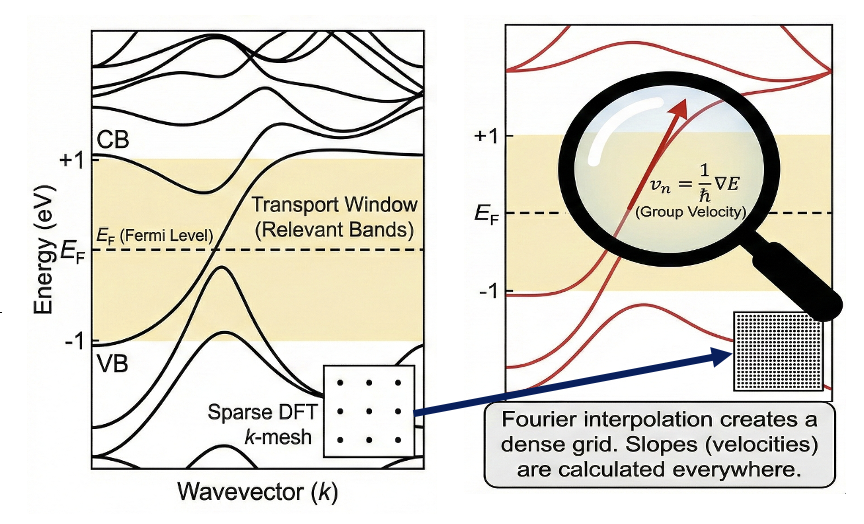

In [4]:
print("="*70)
print("BOLTZTRAP2 INTERPOLATION")
print("="*70)
print(f"Command: btp2 interpolate -m 10 . (run from {work_dir}/)")
print(f"Input mesh:     3×3×1 (25 irreducible k-points)")
print(f"Output mesh:    30×30×10")
print(f"Multiplier:     10× (standard for 2D materials)")
print(f"\nInterpolation starting...\n")

start_time = time.time()

# Run BoltzTraP2 interpolation: Our guy "subprocess" here to run btp2(Boltztrap2 code the same way we would in terminal)
result = subprocess.run(
    ['btp2', 'interpolate', '-m', '10', '.'],
    capture_output=True,
    text=True,
    cwd=work_dir
)

elapsed = time.time() - start_time

# BoltzTraP2 often produces no stdout even on success, so check file existence
bt2_file = os.path.join(work_dir, 'interpolation.bt2') # This sould be generated!

if os.path.exists(bt2_file):
    size_kb = os.path.getsize(bt2_file) / 1024
    print(f"✓ Interpolation completed in {elapsed:.1f} seconds")
    print(f"✓ Output file: interpolation.bt2 ({size_kb:.1f} KB)")
    print(f"\n💡 What was calculated:")
    print(f"  • Fourier-transformed DFT bands")
    print(f"  • Created smooth analytic representation")
    print(f"  • Generated dense k-point mesh (30×30×10)")
    print(f"  • Ready for transport integration")
    
    if result.stderr and 'vtk' not in result.stderr and 'pyfftw' not in result.stderr:
        print(f"\n⚠ Warnings:")
        for line in result.stderr.strip().split('\n'):
            if line:
                print(f"  {line}")
elif result.returncode != 0:
    print(f"✗ Interpolation failed (return code: {result.returncode})")
    print(f"\nStdout:")
    print(result.stdout if result.stdout else "  (empty)")
    print(f"\nStderr:")
    print(result.stderr if result.stderr else "  (empty)")
else:
    print(f"✗ Error: Interpolation ran but output file not created!")
    print(f"  This is unexpected. Please check:")
    print(f"  1. vasprun.xml is valid")
    print(f"  2. Band structure data is present")
    print(f"  3. Energy window includes VBM and CBM")
    if result.stderr:
        print(f"\nStderr:")
        print(result.stderr)

print("="*70)

BOLTZTRAP2 INTERPOLATION
Command: btp2 interpolate -m 10 . (run from BoltzTraP2_Working/)
Input mesh:     3×3×1 (25 irreducible k-points)
Output mesh:    30×30×10
Multiplier:     10× (standard for 2D materials)

Interpolation starting...

✓ Interpolation completed in 4.2 seconds
✓ Output file: interpolation.bt2 (40.5 KB)

💡 What was calculated:
  • Fourier-transformed DFT bands
  • Created smooth analytic representation
  • Generated dense k-point mesh (30×30×10)
  • Ready for transport integration


## Step 4: BoltzTraP2 Integration (Transport Calculation)

### What is Integration?

Now that we have smooth bands everywhere, we calculate **transport properties** by:
1. Solving the **Boltzmann transport equation** at T = 300 K
2. Integrating over all k-points weighted by:
   - **Fermi-Dirac distribution** (thermal occupation)
   - **Band velocities** (how fast electrons move)
   - **Density of states** (how many electrons available)

### Output: `interpolation.trace`

This file contains transport tensors as a function of **chemical potential (μ)**:
- **Column 1**: μ (in Rydberg, we'll convert to eV)
- **Column 5**: Seebeck coefficient diagonal element
- **Column 6**: Conductivity/τ (we multiply by τ = 10⁻¹⁴ s)
- ... and other tensor components

### Relaxation Time (τ)

BoltzTraP2 gives **σ/τ**, not absolute σ. We use **τ = 10⁻¹⁴ s**:
- Typical for organic/MOF materials (from literature)
- Can be experimentally measured or calculated with phonon scattering
- Reasonable approximation for comparison


In [5]:
print("="*70)
print("BOLTZTRAP2 INTEGRATION (Transport Calculation)")
print("="*70)
print(f"Command: btp2 integrate interpolation.bt2 300")
print(f"Temperature:    T = 300 K (room temperature)")
print(f"Method:         Boltzmann transport equation")
print(f"Approximation:  Constant relaxation time (τ = 10⁻¹⁴ s)")
print(f"\nIntegration starting...\n")

start_time = time.time()

# Check if interpolation file exists: It should be there if interpolation succeeded, but we check again to be safe
bt2_file = os.path.join(work_dir, 'interpolation.bt2')
if not os.path.exists(bt2_file):
    print(f"✗ Error: {bt2_file} not found!")
    print(f"  Please run the interpolation step (previous cell) first.")
else:
    # Run BoltzTraP2 integration
    result = subprocess.run(
        ['btp2', 'integrate', 'interpolation.bt2', '300'],
        capture_output=True,
        text=True,
        cwd=work_dir
    )

    elapsed = time.time() - start_time

    # Check if output file was created
    trace_file = os.path.join(work_dir, 'interpolation.trace')
    
    if os.path.exists(trace_file):
        # Success! Load data to count points
        data = np.loadtxt(trace_file, comments='#')
        n_points = len(data)
        size_kb = os.path.getsize(trace_file) / 1024
        print(f"✓ Integration completed in {elapsed:.1f} seconds")
        print(f"✓ Output file: interpolation.trace ({size_kb:.1f} KB, {n_points} μ points)")
        print(f"\n💡 What was calculated:")
        print(f"  • Solved Boltzmann equation at T = 300 K")
        print(f"  • Integrated over all {n_points} chemical potential values")
        print(f"  • Calculated σ(μ), S(μ), and derived PF(μ)")
        print(f"  • Used constant τ approximation")
    elif result.returncode != 0:
        print(f"✗ Integration failed (return code: {result.returncode})")
        print(f"\nError output:")
        print(result.stderr if result.stderr else "  (empty)")
    else:
        print(f"✗ Error: Integration ran but output file not created!")
        print(f"  Check that interpolation.bt2 is valid")
        if result.stderr:
            print(f"\nStderr:")
            print(result.stderr)

print("="*70)

BOLTZTRAP2 INTEGRATION (Transport Calculation)
Command: btp2 integrate interpolation.bt2 300
Temperature:    T = 300 K (room temperature)
Method:         Boltzmann transport equation
Approximation:  Constant relaxation time (τ = 10⁻¹⁴ s)

Integration starting...

✓ Integration completed in 3.9 seconds
✓ Output file: interpolation.trace (185.5 KB, 832 μ points)

💡 What was calculated:
  • Solved Boltzmann equation at T = 300 K
  • Integrated over all 832 chemical potential values
  • Calculated σ(μ), S(μ), and derived PF(μ)
  • Used constant τ approximation


## Step 5: Load and Process Transport Data

### Unit Conversions

BoltzTraP2 uses atomic units (Rydberg), we convert to SI/practical units:

1. **Chemical potential (μ)**:
   - Input: Rydberg (Ry)
   - Conversion: 1 Ry = 13.605693 eV
   - Output: eV (relative to Fermi level)

2. **Seebeck coefficient (S)**:
   - Input: V/K (from trace file)
   - Conversion: × 10⁶
   - Output: μV/K (microvolt per Kelvin)

3. **Conductivity (σ)**:
   - Input: σ/τ in atomic units
   - Conversion: × τ (relaxation time = 10⁻¹⁴ s)
   - Output: S/m (Siemens per meter) = Ω⁻¹·m⁻¹

4. **Power factor (PF)**:
   - Formula: PF = S² × σ
   - Units: (V/K)² × (S/m) = W/(m·K²)
   - Conversion: × 1000 for mW/(m·K²)

In [6]:
print("="*70)
print("LOADING AND PROCESSING TRANSPORT DATA")
print("="*70)

# Constants
RY_TO_EV = 13.605693122994
TAU = 1e-14

# Load interpolation.trace
trace_file = os.path.join(work_dir, 'interpolation.trace')
print(f"Loading {trace_file}...")
data = np.loadtxt(trace_file, comments='#') # Open this file and look at it what does it look?

# Extract columns and convert units
mu_ry = data[:, 0]
mu_ev = mu_ry * RY_TO_EV # Convert chemical potential from Rydberg to eV
seebeck_V_K = data[:, 4]
seebeck_uV_K = seebeck_V_K * 1e6 # Convert Seebeck coefficient from V/K to μV/K
sigma_over_tau = data[:, 5]
sigma_S_m = sigma_over_tau * TAU # Convert conductivity from σ/τ to S/m
# Calculate power factor
power_factor = (seebeck_V_K)**2 * sigma_S_m * 1000 # Convert from W/(m·K²) to mW/(m·K²)

print(f"\n✓ Data loaded: {len(mu_ev)} chemical potential points")
print(f"✓ μ range: {mu_ev.min():.3f} to {mu_ev.max():.3f} eV")
print(f"\n Data Summary:")
print(f"  Seebeck range:     {seebeck_uV_K.min():.1f} to {seebeck_uV_K.max():.1f} μV/K")
print(f"  Conductivity max:  {sigma_S_m.max():.2e} S/m")
print(f"  Power factor max:  {power_factor.max():.2f} mW/(m·K²)")

print(f"\n Unit conversions applied:")
print(f"  μ:  Ry → eV (×{RY_TO_EV:.3f})")
print(f"  S:  V/K → μV/K (×10⁶)")
print(f"  σ:  σ/τ → S/m (×τ = {TAU:.0e} s)")
print(f"  PF: S²σ → mW/(m·K²) (×1000)")

print("="*70)

LOADING AND PROCESSING TRANSPORT DATA
Loading BoltzTraP2_Working/interpolation.trace...

✓ Data loaded: 832 chemical potential points
✓ μ range: -9.322 to 1.408 eV

 Data Summary:
  Seebeck range:     -1549.4 to 1549.4 μV/K
  Conductivity max:  8.44e+04 S/m
  Power factor max:  0.49 mW/(m·K²)

 Unit conversions applied:
  μ:  Ry → eV (×13.606)
  S:  V/K → μV/K (×10⁶)
  σ:  σ/τ → S/m (×τ = 1e-14 s)
  PF: S²σ → mW/(m·K²) (×1000)


## Data Range Visualization

Let's examine the full range of transport properties to understand the material's behavior across all doping levels.

In [7]:
print("="*70)
print("DETAILED TRANSPORT PROPERTY RANGES")
print("="*70)

# Find extrema
mu_min, mu_max = mu_ev.min(), mu_ev.max()
S_min, S_max = seebeck_uV_K.min(), seebeck_uV_K.max()
sigma_min, sigma_max = sigma_S_m.min(), sigma_S_m.max()
PF_min, PF_max = power_factor.min(), power_factor.max()

# Find where extrema occur
idx_S_min = np.argmin(seebeck_uV_K)
idx_S_max = np.argmax(seebeck_uV_K)
idx_sigma_max = np.argmax(sigma_S_m)
idx_PF_max = np.argmax(power_factor)

print("\n" + "━"*70)
print("📊 SEEBECK COEFFICIENT (S)")
print("━"*70)
print(f"  Full Range:       {S_min:+8.1f} to {S_max:+8.1f} μV/K")
print(f"  Span:             {S_max - S_min:8.1f} μV/K")
print(f"\n  Maximum (p-type): S = {S_max:+8.1f} μV/K  at  μ = {mu_ev[idx_S_max]:+7.4f} eV")
print(f"  Minimum (n-type): S = {S_min:+8.1f} μV/K  at  μ = {mu_ev[idx_S_min]:+7.4f} eV")
print(f"\n  💡 Interpretation:")
print(f"     • Positive S → Holes dominate (p-type behavior)")
print(f"     • Negative S → Electrons dominate (n-type behavior)")
print(f"     • Large |S| → Strong thermoelectric voltage generation")

print("\n" + "━"*70)
print("⚡ ELECTRICAL CONDUCTIVITY (σ)")
print("━"*70)
print(f"  Range:            {sigma_min:.2e} to {sigma_max:.2e} S/m")
print(f"  Maximum:          σ = {sigma_max:.2e} S/m  at  μ = {mu_ev[idx_sigma_max]:+7.4f} eV")
print(f"  (Scaled):         {sigma_max*1e-10:.2f} × 10¹⁰ S/m")
print(f"\n  💡 Interpretation:")
print(f"     • Low σ in bandgap (insulating)")
print(f"     • High σ far from E_F (good conductor)")
print(f"     • Assumes τ = {TAU:.0e} s")

print("\n" + "━"*70)
print("🔋 POWER FACTOR (PF = S²σ)")
print("━"*70)
print(f"  Range:            {PF_min:.2f} to {PF_max:.2f} mW/(m·K²)")
print(f"  Maximum:          PF = {PF_max:.2f} mW/(m·K²)  at  μ = {mu_ev[idx_PF_max]:+7.4f} eV")
print(f"\n  💡 Interpretation:")
print(f"     • PF combines S and σ (both important!)")
print(f"     • Peak PF indicates optimal doping level")
print(f"     • Higher PF → better thermoelectric performance")

print("\n" + "━"*70)
print("🎯 CHEMICAL POTENTIAL RANGE")
print("━"*70)
print(f"  Full range:       {mu_min:+7.4f} to {mu_max:+7.4f} eV")
print(f"  Span:             {mu_max - mu_min:7.4f} eV")
print(f"  Reference:        E_F = 0.0000 eV (Fermi level)")
print(f"\n  Typical plotting range: ±0.5 eV around E_F")
print(f"  (Covers experimentally accessible doping levels)")

print("\n" + "="*70)
print("✓ Data range analysis complete")
print("="*70)

DETAILED TRANSPORT PROPERTY RANGES

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 SEEBECK COEFFICIENT (S)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Full Range:        -1549.4 to  +1549.4 μV/K
  Span:               3098.9 μV/K

  Maximum (p-type): S =  +1549.4 μV/K  at  μ = -2.2075 eV
  Minimum (n-type): S =  -1549.4 μV/K  at  μ = -1.4199 eV

  💡 Interpretation:
     • Positive S → Holes dominate (p-type behavior)
     • Negative S → Electrons dominate (n-type behavior)
     • Large |S| → Strong thermoelectric voltage generation

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ ELECTRICAL CONDUCTIVITY (σ)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Range:            0.00e+00 to 8.44e+04 S/m
  Maximum:          σ = 8.44e+04 S/m  at  μ = -9.1671 eV
  (Scaled):         0.00 × 10¹⁰ S/m

  💡 Interpretation:
     • Low σ in bandgap (insulating)
     • High σ far from E_F (good conduc

## Final Transport Properties Plot

Publication-quality three-panel plot showing Seebeck coefficient, conductivity, and power factor vs chemical potential.

# Plot full chemical potential range without shifting

✓ High-resolution plot saved: transport_properties_ZnPHC_with_bands.png

📍 Band edge positions:
  VBM (Valence Band Max):  -4.0586 eV
  E_F (Fermi Energy):      -4.0583 eV
  CBM (Conduction Band):   -3.3828 eV
  Bandgap:                 0.6758 eV


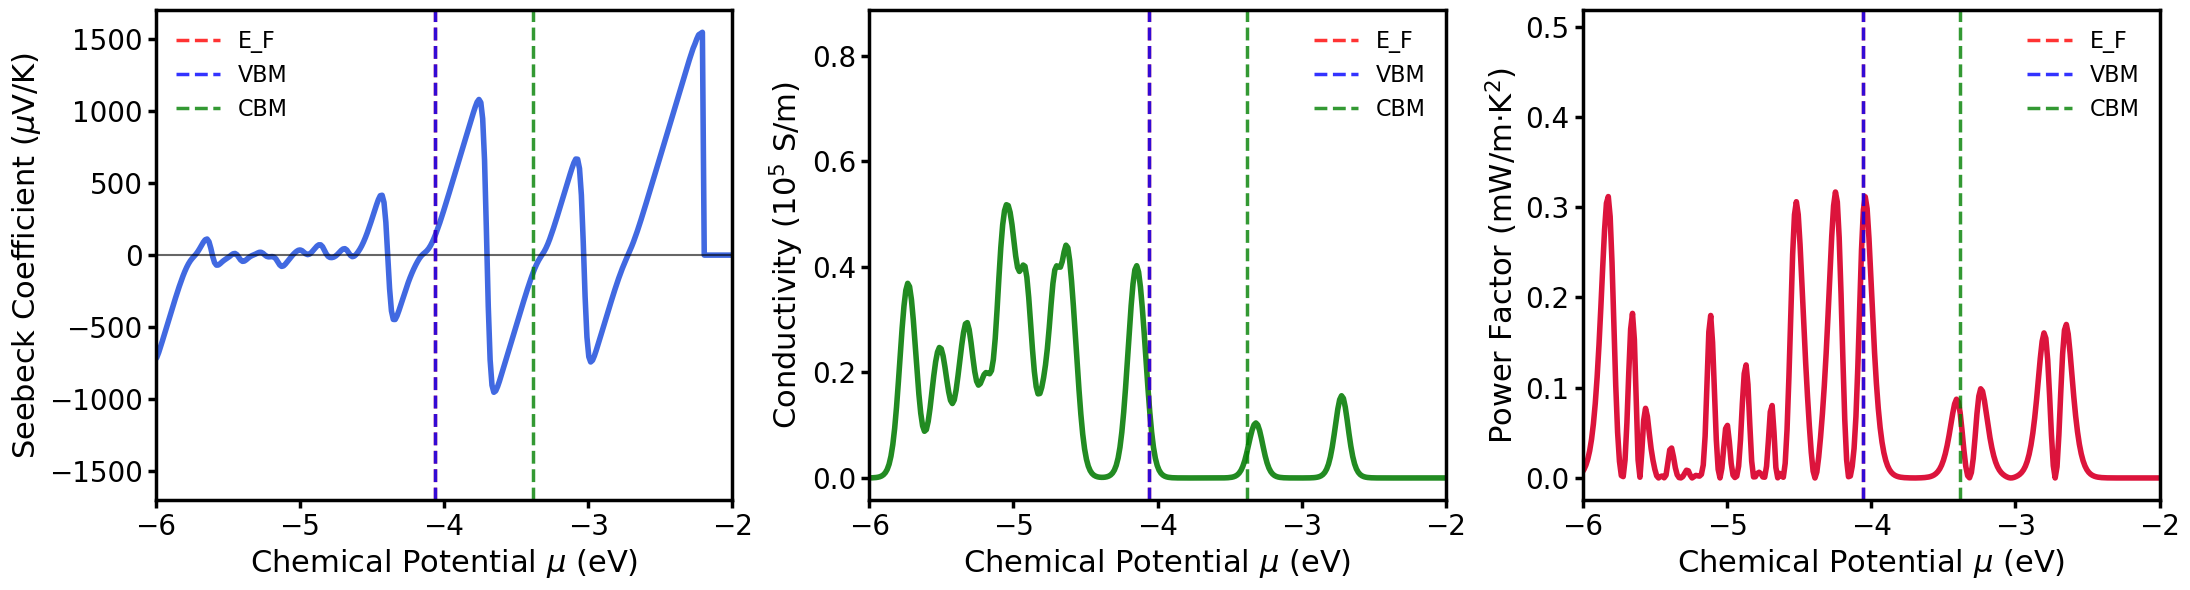

In [10]:

vasprun_path = os.path.join(work_dir, 'vasprun.xml')
vasprun_full = Vasprun(vasprun_path, parse_projected_eigen=False)
bs_full = vasprun_full.get_band_structure()
efermi_full = vasprun_full.efermi
vbm_full = bs_full.get_vbm()['energy']
cbm_full = bs_full.get_cbm()['energy']

# Use full data range (no filtering)
mu_plot_full = mu_ev
seebeck_plot_full = seebeck_uV_K
sigma_plot_full = sigma_S_m
pf_plot_full = power_factor

# Create publication-quality plot
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

LINE_WIDTH = 4.0
LABEL_FONT = 22
TICK_FONT = 20
BOX_WIDTH = 2.5

# Panel 1: Seebeck Coefficient
axes[0].plot(mu_plot_full, seebeck_plot_full, color='royalblue', lw=LINE_WIDTH)
axes[0].axhline(0, color='black', ls='-', lw=1.5, alpha=0.6)
axes[0].axvline(efermi_full, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[0].axvline(vbm_full, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[0].axvline(cbm_full, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[0].set_xlabel(r'Chemical Potential $\mu$ (eV)', fontsize=LABEL_FONT)
axes[0].set_ylabel(r'Seebeck Coefficient ($\mu$V/K)', fontsize=LABEL_FONT)
axes[0].set_xlim(-6, -2)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[0].legend(fontsize=16, frameon=False)
for spine in axes[0].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 2: Conductivity (Scaled to 10^5)
axes[1].plot(mu_plot_full, sigma_plot_full / 1e5, color='forestgreen', lw=LINE_WIDTH)
axes[1].axvline(efermi_full, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[1].axvline(vbm_full, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[1].axvline(cbm_full, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[1].set_xlabel(r'Chemical Potential $\mu$ (eV)', fontsize=LABEL_FONT)
axes[1].set_ylabel(r'Conductivity ($10^5$ S/m)', fontsize=LABEL_FONT)
axes[1].set_xlim(-6, -2)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[1].legend(fontsize=16, frameon=False)
for spine in axes[1].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 3: Power Factor
axes[2].plot(mu_plot_full, pf_plot_full, color='crimson', lw=LINE_WIDTH)
axes[2].axvline(efermi_full, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[2].axvline(vbm_full, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[2].axvline(cbm_full, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[2].set_xlabel(r'Chemical Potential $\mu$ (eV)', fontsize=LABEL_FONT)
axes[2].set_ylabel(r'Power Factor (mW/m$\cdot$K$^2$)', fontsize=LABEL_FONT)
axes[2].set_xlim(-6, -2)
axes[2].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[2].legend(fontsize=16, frameon=False)
for spine in axes[2].spines.values():
    spine.set_linewidth(BOX_WIDTH)

plt.tight_layout()
#plt.savefig('transport_properties_ZnPHC_with_bands.png', dpi=300, bbox_inches='tight') # Uncomment this line to save the figure as a high-resolution PNG file
print(f"✓ High-resolution plot saved: transport_properties_ZnPHC_with_bands.png")
print(f"\n📍 Band edge positions:")
print(f"  VBM (Valence Band Max):  {vbm_full:.4f} eV")
print(f"  E_F (Fermi Energy):      {efermi_full:.4f} eV")
print(f"  CBM (Conduction Band):   {cbm_full:.4f} eV")
print(f"  Bandgap:                 {cbm_full - vbm_full:.4f} eV")
plt.show()

# Plot with bandgap centered at zero (VBM at -Eg/2, CBM at +Eg/2)

✓ High-resolution plot saved: transport_properties_ZnPHC_centered.png

📍 Band edge positions (centered at bandgap):
  VBM:  -0.3379 eV  (= -Eg/2)
  Zero: 0.0000 eV  (bandgap center)
  CBM:  0.3379 eV  (= +Eg/2)
  E_F:  -0.3376 eV  (Fermi level)
  Bandgap: 0.6758 eV


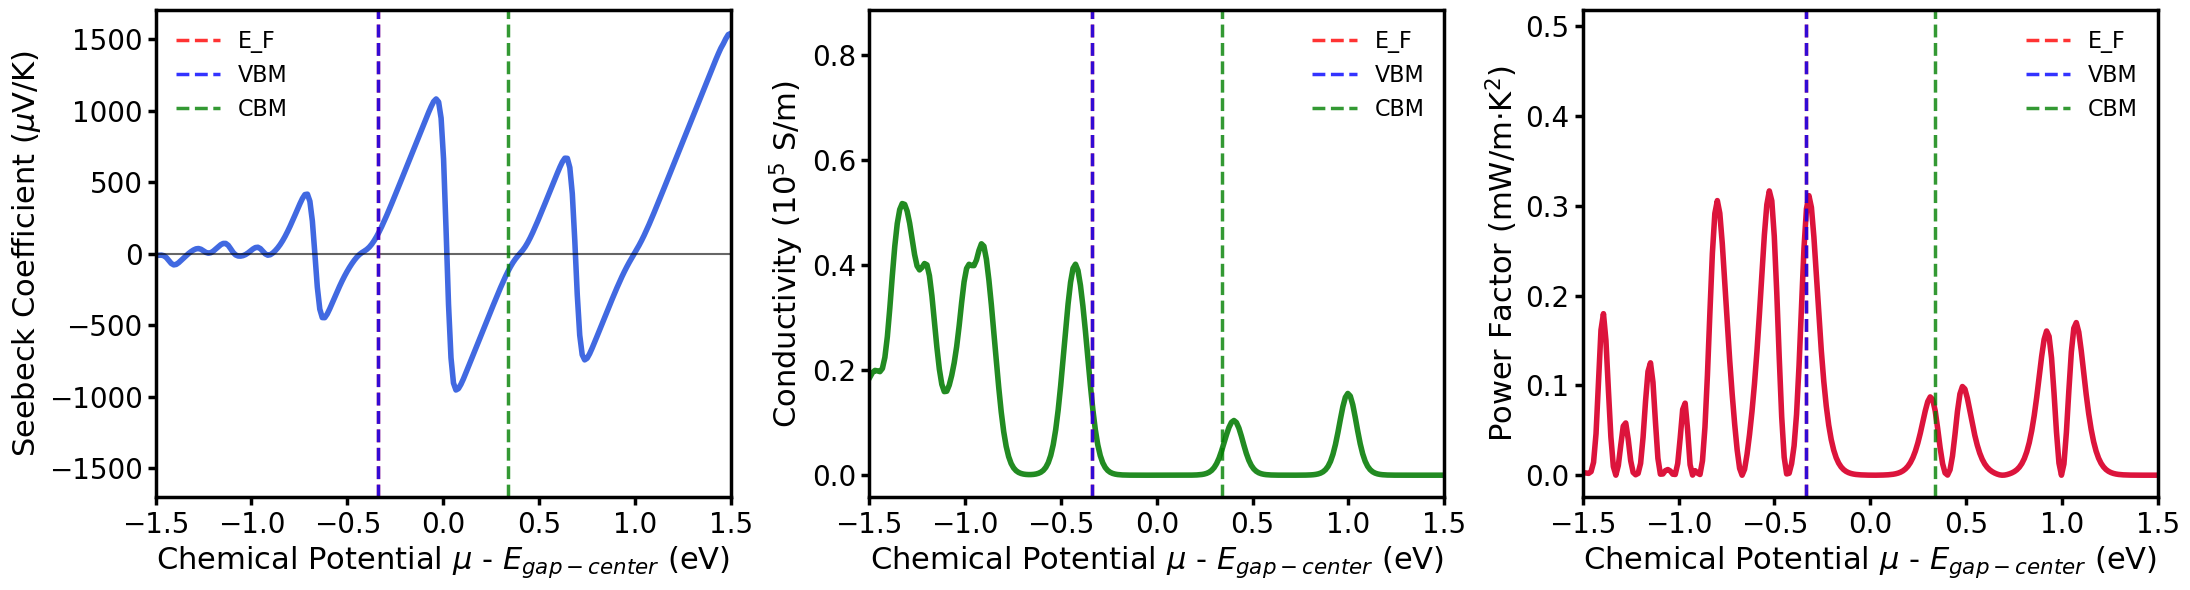

In [11]:
# Plot with bandgap centered at zero (VBM at -Eg/2, CBM at +Eg/2)
vasprun_path = os.path.join(work_dir, 'vasprun.xml')
vasprun_centered = Vasprun(vasprun_path, parse_projected_eigen=False)
bs_centered = vasprun_centered.get_band_structure()
efermi_centered = vasprun_centered.efermi
vbm_centered = bs_centered.get_vbm()['energy']
cbm_centered = bs_centered.get_cbm()['energy']
bandgap = cbm_centered - vbm_centered

# Calculate shift to center the bandgap at zero
# We want VBM at -Eg/2 and CBM at +Eg/2
bandgap_center = (vbm_centered + cbm_centered) / 2.0
mu_shifted_centered = mu_ev - bandgap_center

# Shift band edge positions
vbm_shifted = vbm_centered - bandgap_center  # Should be -Eg/2
cbm_shifted = cbm_centered - bandgap_center  # Should be +Eg/2
efermi_shifted = efermi_centered - bandgap_center

# Use full data range
seebeck_centered = seebeck_uV_K
sigma_centered = sigma_S_m
pf_centered = power_factor

# Create publication-quality plot
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

LINE_WIDTH = 4.0
LABEL_FONT = 22
TICK_FONT = 20
BOX_WIDTH = 2.5

# Panel 1: Seebeck Coefficient
axes[0].plot(mu_shifted_centered, seebeck_centered, color='royalblue', lw=LINE_WIDTH)
axes[0].axhline(0, color='black', ls='-', lw=1.5, alpha=0.6)
axes[0].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[0].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[0].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[0].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[0].set_ylabel(r'Seebeck Coefficient ($\mu$V/K)', fontsize=LABEL_FONT)
axes[0].set_xlim(-1.5, 1.5)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[0].legend(fontsize=16, frameon=False)
for spine in axes[0].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 2: Conductivity (Scaled to 10^5)
axes[1].plot(mu_shifted_centered, sigma_centered / 1e5, color='forestgreen', lw=LINE_WIDTH)
axes[1].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[1].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[1].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[1].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[1].set_ylabel(r'Conductivity ($10^5$ S/m)', fontsize=LABEL_FONT)
axes[1].set_xlim(-1.5, 1.5)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[1].legend(fontsize=16, frameon=False)
for spine in axes[1].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 3: Power Factor
axes[2].plot(mu_shifted_centered, pf_centered, color='crimson', lw=LINE_WIDTH)
axes[2].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[2].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[2].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[2].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[2].set_ylabel(r'Power Factor (mW/m$\cdot$K$^2$)', fontsize=LABEL_FONT)
axes[2].set_xlim(-1.5, 1.5)
axes[2].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[2].legend(fontsize=16, frameon=False)
for spine in axes[2].spines.values():
    spine.set_linewidth(BOX_WIDTH)

plt.tight_layout()
#plt.savefig('transport_properties_ZnPHC_centered.png', dpi=300, bbox_inches='tight')
print(f"✓ High-resolution plot saved: transport_properties_ZnPHC_centered.png")
print(f"\n📍 Band edge positions (centered at bandgap):")
print(f"  VBM:  {vbm_shifted:.4f} eV  (= -Eg/2)")
print(f"  Zero: {0.0:.4f} eV  (bandgap center)")
print(f"  CBM:  {cbm_shifted:.4f} eV  (= +Eg/2)")
print(f"  E_F:  {efermi_shifted:.4f} eV  (Fermi level)")
print(f"  Bandgap: {bandgap:.4f} eV")
plt.show()


# Plot with bandgap centered at zero and set x-limits between -BG/2 ro BG/2

✓ High-resolution plot saved: transport_properties_ZnPHC_centered.png

📍 Band edge positions (centered at bandgap):
  VBM:  -0.3379 eV  (= -Eg/2)
  Zero: 0.0000 eV  (bandgap center)
  CBM:  0.3379 eV  (= +Eg/2)
  E_F:  -0.3376 eV  (Fermi level)
  Bandgap: 0.6758 eV


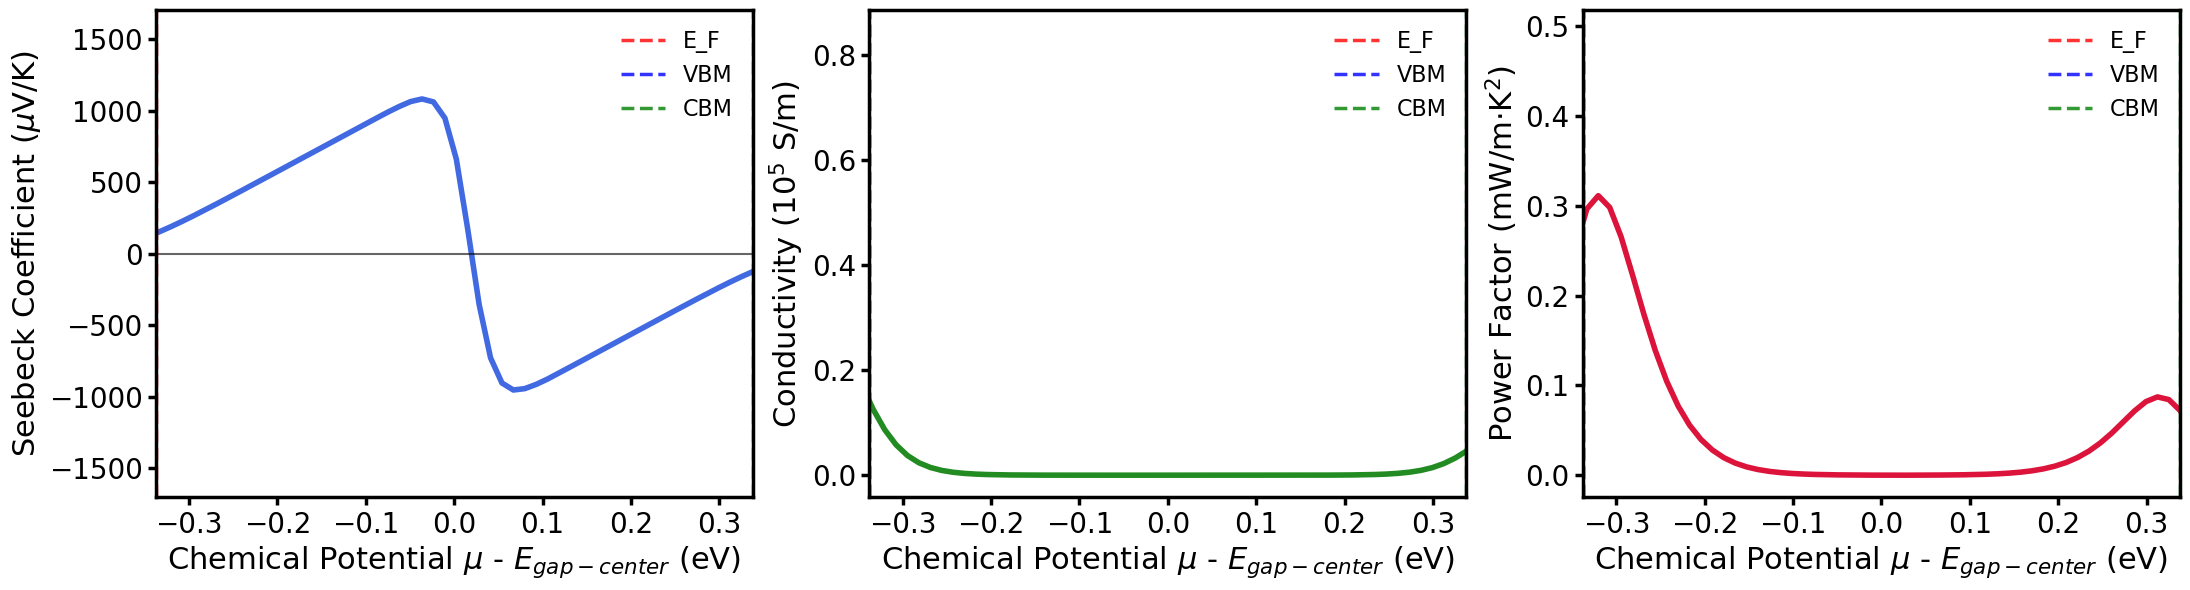

In [12]:

vasprun_path = os.path.join(work_dir, 'vasprun.xml')
vasprun_centered = Vasprun(vasprun_path, parse_projected_eigen=False)
bs_centered = vasprun_centered.get_band_structure()
efermi_centered = vasprun_centered.efermi
vbm_centered = bs_centered.get_vbm()['energy']
cbm_centered = bs_centered.get_cbm()['energy']
bandgap = cbm_centered - vbm_centered

# Calculate shift to center the bandgap at zero
# We want VBM at -Eg/2 and CBM at +Eg/2
bandgap_center = (vbm_centered + cbm_centered) / 2.0
mu_shifted_centered = mu_ev - bandgap_center

# Shift band edge positions
vbm_shifted = vbm_centered - bandgap_center  # Should be -Eg/2
cbm_shifted = cbm_centered - bandgap_center  # Should be +Eg/2
efermi_shifted = efermi_centered - bandgap_center

# Use full data range
seebeck_centered = seebeck_uV_K
sigma_centered = sigma_S_m
pf_centered = power_factor

# Create publication-quality plot
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

LINE_WIDTH = 4.0
LABEL_FONT = 22
TICK_FONT = 20
BOX_WIDTH = 2.5

# Panel 1: Seebeck Coefficient
axes[0].plot(mu_shifted_centered, seebeck_centered, color='royalblue', lw=LINE_WIDTH)
axes[0].axhline(0, color='black', ls='-', lw=1.5, alpha=0.6)
axes[0].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[0].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[0].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[0].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[0].set_ylabel(r'Seebeck Coefficient ($\mu$V/K)', fontsize=LABEL_FONT)
axes[0].set_xlim(-bandgap/2, bandgap/2)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[0].legend(fontsize=16, frameon=False)
for spine in axes[0].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 2: Conductivity (Scaled to 10^5)
axes[1].plot(mu_shifted_centered, sigma_centered / 1e5, color='forestgreen', lw=LINE_WIDTH)
axes[1].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[1].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[1].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[1].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[1].set_ylabel(r'Conductivity ($10^5$ S/m)', fontsize=LABEL_FONT)
axes[1].set_xlim(-bandgap/2, bandgap/2)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[1].legend(fontsize=16, frameon=False)
for spine in axes[1].spines.values():
    spine.set_linewidth(BOX_WIDTH)

# Panel 3: Power Factor
axes[2].plot(mu_shifted_centered, pf_centered, color='crimson', lw=LINE_WIDTH)
axes[2].axvline(efermi_shifted, color='red', ls='--', lw=2.5, alpha=0.8, label=f'E_F')
axes[2].axvline(vbm_shifted, color='blue', ls='--', lw=2.5, alpha=0.8, label=f'VBM')
axes[2].axvline(cbm_shifted, color='green', ls='--', lw=2.5, alpha=0.8, label=f'CBM')
axes[2].set_xlabel(r'Chemical Potential $\mu$ - $E_{gap-center}$ (eV)', fontsize=LABEL_FONT)
axes[2].set_ylabel(r'Power Factor (mW/m$\cdot$K$^2$)', fontsize=LABEL_FONT)
axes[2].set_xlim(-bandgap/2, bandgap/2)
axes[2].tick_params(axis='both', which='major', labelsize=TICK_FONT, width=BOX_WIDTH, length=6)
axes[2].legend(fontsize=16, frameon=False)
for spine in axes[2].spines.values():
    spine.set_linewidth(BOX_WIDTH)

plt.tight_layout()
plt.savefig('transport_properties_ZnPHC_centered.png', dpi=300, bbox_inches='tight')
print(f"✓ High-resolution plot saved: transport_properties_ZnPHC_centered.png")
print(f"\n📍 Band edge positions (centered at bandgap):")
print(f"  VBM:  {vbm_shifted:.4f} eV  (= -Eg/2)")
print(f"  Zero: {0.0:.4f} eV  (bandgap center)")
print(f"  CBM:  {cbm_shifted:.4f} eV  (= +Eg/2)")
print(f"  E_F:  {efermi_shifted:.4f} eV  (Fermi level)")
print(f"  Bandgap: {bandgap:.4f} eV")
plt.show()


# Additionals: Extract full Seebeck tensor (S_xx, S_yy, S_zz) from .btj file
 - The same can be done for electrical conudctivity


Anisotropy: |S_xx-S_yy|_max = 34.62 μV/K, |S_xx-S_zz|_max = 791.69 μV/K


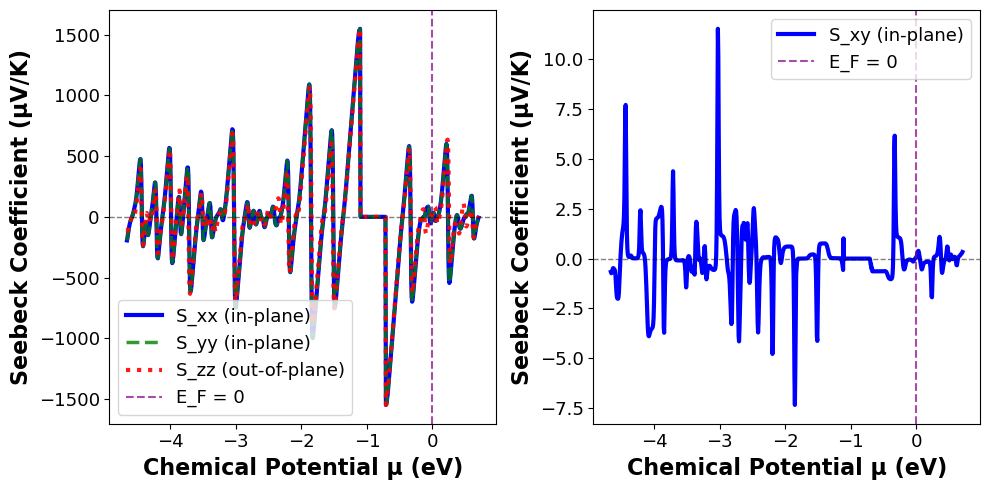

In [13]:

import lzma
import json

btj_file = os.path.join(work_dir, 'interpolation.btj')
with lzma.open(btj_file, 'rb') as f:
    data = json.loads(f.read().decode('utf-8'))

mu_ry = np.array(data[4]['data'])
mu_eV = mu_ry * 13.605693122994
S_tensor = np.array(data[9]['data'])

# Extract diagonal components (T=300K, index 0)
S_xx = S_tensor[0, :, 0, 0] * 1e6  # V/K to μV/K
S_yy = S_tensor[0, :, 1, 1] * 1e6
S_zz = S_tensor[0, :, 2, 2] * 1e6

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mu_eV, S_xx, 'b-', lw=3, label='S_xx (in-plane)')
ax[0].plot(mu_eV, S_yy, 'g--', lw=2.5, alpha=0.8, label='S_yy (in-plane)')
ax[0].plot(mu_eV, S_zz, 'r:', lw=3, alpha=0.9, label='S_zz (out-of-plane)')
ax[0].axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax[0].axvline(0, color='purple', ls='--', lw=1.5, alpha=0.7, label='E_F = 0')
ax[0].set_xlabel('Chemical Potential μ (eV)', fontsize=16, fontweight='bold')
ax[0].set_ylabel('Seebeck Coefficient (μV/K)', fontsize=16, fontweight='bold')
#ax[0].set_title('Seebeck Tensor Components (T=300K)', fontsize=18, fontweight='bold')
ax[0].legend(fontsize=13, loc='best')
#ax[0].grid(True, alpha=0.3)
ax[0].tick_params(labelsize=13)
#plt.tight_layout()
#plt.savefig(os.path.join(work_dir, 'seebeck_tensor.png'), dpi=300, bbox_inches='tight')
#plt.show()

# Anisotropy check
diff_xy = np.abs(S_xx - S_yy).max()
diff_xz = np.abs(S_xx - S_zz).max()
print(f"\nAnisotropy: |S_xx-S_yy|_max = {diff_xy:.2f} μV/K, |S_xx-S_zz|_max = {diff_xz:.2f} μV/K")


#Let's plot off diagonal terms

# Extract diagonal components (T=300K, index 0)
S_xy = S_tensor[0, :, 0, 1] * 1e6  # V/K to μV/K

#fig, ax = plt.subplots(figsize=(12, 7))
ax[1].plot(mu_eV, S_xy, 'b-', lw=3, label='S_xy (in-plane)')
#ax.plot(mu_eV, S_yy, 'g--', lw=2.5, alpha=0.8, label='S_yy (in-plane)')
#ax.plot(mu_eV, S_zz, 'r:', lw=3, alpha=0.9, label='S_zz (out-of-plane)')
ax[1].axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax[1].axvline(0, color='purple', ls='--', lw=1.5, alpha=0.7, label='E_F = 0')
ax[1].set_xlabel('Chemical Potential μ (eV)', fontsize=16, fontweight='bold')
ax[1].set_ylabel('Seebeck Coefficient (μV/K)', fontsize=16, fontweight='bold')
#ax[1].set_title('Seebeck Tensor Components (T=300K)', fontsize=18, fontweight='bold')
ax[1].legend(fontsize=13, loc='best')
#ax[1].grid(True, alpha=0.3)
ax[1].tick_params(labelsize=13)
plt.tight_layout()
#plt.savefig(os.path.join(work_dir, 'seebeck_tensor.png'), dpi=300, bbox_inches='tight')
plt.show()